# Assignment 2.2

Based on *Lecture 10.2 Object Detection*.

In [1]:
import pathlib
import warnings

In [2]:
import imageio
import json
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision.models.detection import faster_rcnn
from tqdm.auto import tqdm

Mount your Google Drive to access files within. File paths below assume:
1. You have created a shortcut to the shared folder,
2. Placed it at the top level, and
3. Renamed it to "DLMI".

In [3]:
import google
google.colab.drive.mount('/content/drive', force_remount=True)
drive = pathlib.Path('./drive/MyDrive') / 'DLMI'

Mounted at /content/drive


Ignore deprecation warning (resolved [here](https://github.com/pytorch/vision/pull/4645)).

In [4]:
warnings.filterwarnings('ignore', message='torch.meshgrid', category=UserWarning)

## Dataset preparation

In [5]:
class DatasetBrainTumorMRI(torch.utils.data.Dataset):

    def __init__(self, directory, subset, transform=None):
        super().__init__()
        
        self._filepath = pathlib.Path(directory) / f'{subset}/annotations_{subset}.json'
        with self._filepath.open() as f:
            self._annotations = list(json.load(f).values())
        self._transform = transform

    def __len__(self):
        return len(self._annotations)

    def __getitem__(self, index):
        annotation = self._annotations[index]

        filepath = self._filepath.parent / annotation['filename']
        image = imageio.imread(filepath)
        image = image.transpose([2,0,1]).astype(np.float32) / 255

        boxes = []
        for region in annotation['regions']:
            xs = region['shape_attributes']['all_points_x']
            ys = region['shape_attributes']['all_points_y']
            boxes.append([min(xs), min(ys), max(xs), max(ys)])
        areas = [(xmax - xmin) * (ymax - ymin) for xmin, ymin, xmax, ymax in boxes]

        target = {}
        target['boxes'] = np.array(boxes, dtype=np.float32)
        target['labels'] = np.ones(len(boxes), dtype=np.int64)
        target['image_id'] = np.array([index], dtype=np.int64)
        target['area'] = np.array(areas, dtype=np.float32)
        target['iscrowd'] = np.zeros(len(boxes), dtype=np.int64)

        image = torch.as_tensor(image.copy())
        for key, value in target.items():
            target[key] = torch.as_tensor(value.copy())

        if self._transform is not None:
            image, target = self._transform([image, target])

        return image, target

In [6]:
def collate(batch):
    return tuple(zip(*batch))

In [7]:
data = drive / 'datasets/BrainTumorMRI'

loader_train = torch.utils.data.DataLoader(
    dataset=DatasetBrainTumorMRI(data, 'train'),
    batch_size=10,
    shuffle=True,
    collate_fn=collate)

loader_val = torch.utils.data.DataLoader(
    dataset=DatasetBrainTumorMRI(data, 'val'),
    batch_size=10,
    collate_fn=collate)

loader_test = torch.utils.data.DataLoader(
    dataset=DatasetBrainTumorMRI(data, 'test'),
    collate_fn=collate)

<ipython-input-5-edf59ec4f5c3>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


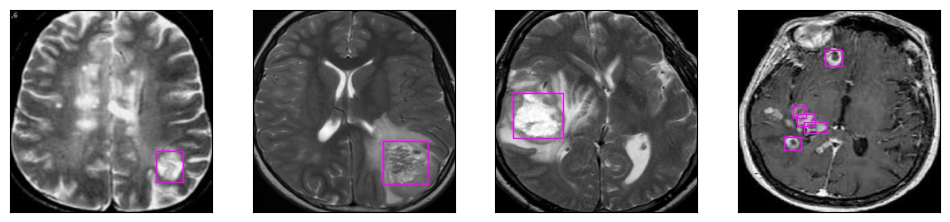

In [8]:
nimages = 4
fig, axs = plt.subplots(ncols=nimages, figsize=(nimages*3,3), subplot_kw={'xticks': [], 'yticks': []})
i = 0
for images, targets in loader_train:
    if i >= nimages:
        break
    for image, target in zip(images, targets):
        if i >= nimages:
            break
        axs[i].imshow(image.numpy().transpose((1,2,0)))
        for xmin, ymin, xmax, ymax in target['boxes']:
            axs[i].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, ec='magenta', fc='none'))
        i += 1

## Model training

In [9]:
model = faster_rcnn.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
for name, child in model.named_children():
    print(name)
    for name2, child2 in child.named_children():
        print('    ', name2)

transform
backbone
     body
     fpn
rpn
     anchor_generator
     head
roi_heads
     box_roi_pool
     box_head
     box_predictor


*Hint:* Follow example customization below to solve Q2b.

Customize `box_predictor`.

In [26]:
class FastRCNNPredictor(torch.nn.Module):

    def __init__(self, in_features, num_classes):
        super().__init__()
        self.drop_out= torch.nn.Dropout(p=0.5)
        self.cls_score = torch.nn.Linear(in_features, num_classes)
        self.bbox_pred = torch.nn.Linear(in_features, num_classes * 4)

    def forward(self, x):
        x = self.drop_out(x)
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

In [12]:
in_features = model.roi_heads.box_head.fc7.out_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

In [13]:
device = torch.device('cuda')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 30
losses_train = []
losses_val = []


*Hint:* Keep track of individual losses as you train the network (Q2a).

In [14]:
device = torch.device('cuda')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 30
losses_train = []
losses_val = []
classification_losses_train = []
box_regression_losses_train = []
rpn_objectness_losses_train = []
rpn_anchor_losses_train = []

classification_losses_val = []
box_regression_losses_val = []
rpn_objectness_losses_val = []
rpn_anchor_losses_val = []

In [27]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_train = []
    classification_loss_running = []
    box_regression_loss_running = []
    rpn_objectness_loss_running = []
    rpn_anchor_loss_running = []

    for images, targets in loader_train:
        optimizer.zero_grad()
        images = [x.to(device) for x in images]
        targets = [{k: v.to(device) for k, v in x.items()} for x in targets]
        losses = model(images, targets)
        list_loss = list(losses.values())
        classification_loss_running.append(list_loss[0].cpu().detach().numpy())
        box_regression_loss_running.append(list_loss[1].cpu().detach().numpy())
        rpn_objectness_loss_running.append(list_loss[2].cpu().detach().numpy())
        rpn_anchor_loss_running.append(list_loss[3].cpu().detach().numpy())
        loss = sum(losses.values())
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
    losses_train.append(sum(loss_train) / loader_train.batch_size)
    classification_losses_train.append(sum(classification_loss_running) / loader_train.batch_size)
    box_regression_losses_train.append(sum(box_regression_loss_running) / loader_train.batch_size)
    rpn_objectness_losses_train.append(sum(rpn_objectness_loss_running) / loader_train.batch_size)
    rpn_anchor_losses_train.append(sum(rpn_anchor_loss_running) / loader_train.batch_size)

    with torch.no_grad():
       
        loss_val = []
        classification_loss_running = []
        box_regression_loss_running = []
        rpn_objectness_loss_running = []
        rpn_anchor_loss_running = []

        for images, targets in loader_val:
            images = [x.to(device) for x in images]
            targets = [{k: v.to(device) for k, v in x.items()} for x in targets]
            losses = model(images, targets)
            list_loss = list(losses.values())
            classification_loss_running.append(list_loss[0].cpu().detach().numpy())
            box_regression_loss_running.append(list_loss[1].cpu().detach().numpy())
            rpn_objectness_loss_running.append(list_loss[2].cpu().detach().numpy())
            rpn_anchor_loss_running.append(list_loss[3].cpu().detach().numpy())
            loss = sum(losses.values())
            loss_val.append(loss.item())
        losses_val.append(sum(loss_val) / loader_val.batch_size)
        classification_losses_val.append(sum(classification_loss_running) / loader_train.batch_size)
        box_regression_losses_val.append(sum(box_regression_loss_running) / loader_train.batch_size)
        rpn_objectness_losses_val.append(sum(rpn_objectness_loss_running) / loader_train.batch_size)
        rpn_anchor_losses_val.append(sum(rpn_anchor_loss_running) / loader_train.batch_size)


  0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-5-edf59ec4f5c3>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


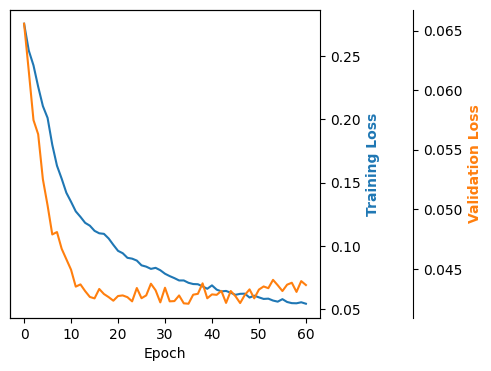

In [28]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(losses_train, 'C0')
ax.set_ylabel('Training Loss', c='C0', fontweight='bold')
ax2 = ax.twinx()
ax2.plot(losses_val, 'C1')
ax2.set_ylabel('Validation Loss', c='C1', fontweight='bold')
ax2.spines['right'].set_position(('axes', 1 + 0.3))
ax.set_xlabel('Epoch')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
pass





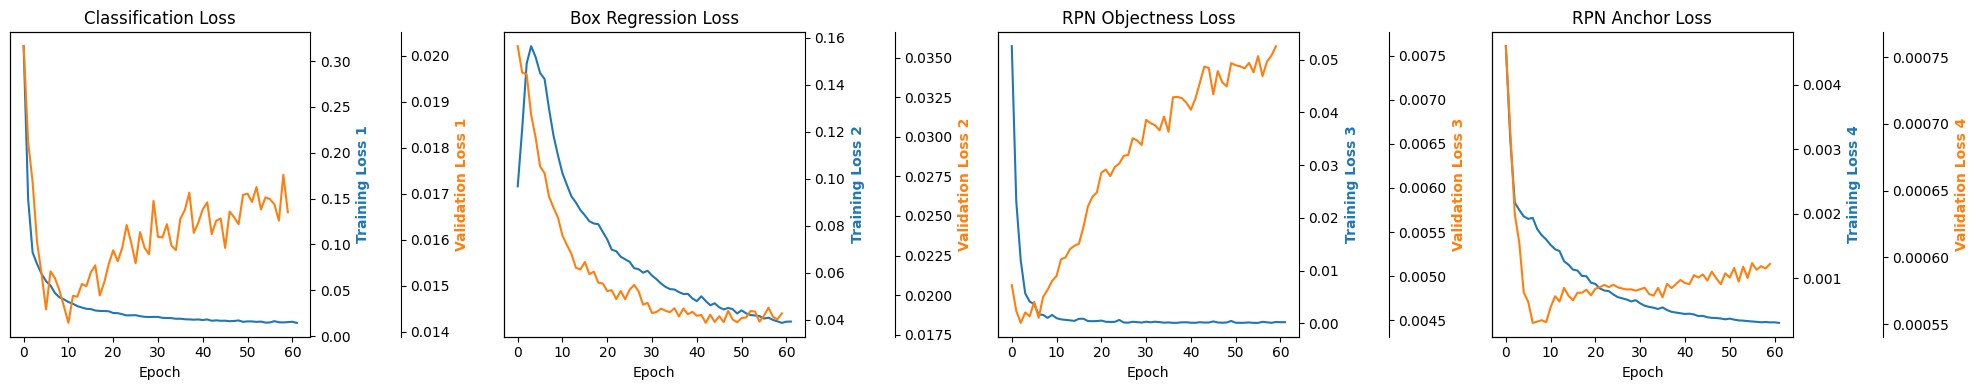

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

# Loss 1
axs[0].plot(classification_losses_train, 'C0')
axs[0].set_ylabel('Training Loss 1', c='C0', fontweight='bold')
axs[0].set_title('Classification Loss')
ax2 = axs[0].twinx()
ax2.plot(classification_losses_val, 'C1')
ax2.set_ylabel('Validation Loss 1', c='C1', fontweight='bold')
ax2.spines['right'].set_position(('axes', 1 + 0.3))
axs[0].set_xlabel('Epoch')
axs[0].yaxis.tick_right()
axs[0].yaxis.set_label_position('right')

# Loss 2
axs[1].plot(box_regression_losses_train, 'C0')
axs[1].set_ylabel('Training Loss 2', c='C0', fontweight='bold')
axs[1].set_title('Box Regression Loss')
ax2 = axs[1].twinx()
ax2.plot(box_regression_losses_val, 'C1')
ax2.set_ylabel('Validation Loss 2', c='C1', fontweight='bold')
ax2.spines['right'].set_position(('axes', 1 + 0.3))
axs[1].set_xlabel('Epoch')
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position('right')

# Loss 3
axs[2].plot(rpn_objectness_losses_train, 'C0')
axs[2].set_ylabel('Training Loss 3', c='C0', fontweight='bold')
axs[2].set_title('RPN Objectness Loss')
ax2 = axs[2].twinx()
ax2.plot(rpn_objectness_losses_val, 'C1')
ax2.set_ylabel('Validation Loss 3', c='C1', fontweight='bold')
ax2.spines['right'].set_position(('axes', 1 + 0.3))
axs[2].set_xlabel('Epoch')
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position('right')

# Loss 4
axs[3].plot(rpn_anchor_losses_train, 'C0')
axs[3].set_ylabel('Training Loss 4', c='C0', fontweight='bold')
axs[3].set_title('RPN Anchor Loss')
ax2 = axs[3].twinx()
ax2.plot(rpn_anchor_losses_val, 'C1')
ax2.set_ylabel('Validation Loss 4', c='C1', fontweight='bold')
ax2.spines['right'].set_position(('axes', 1 + 0.3))
axs[3].set_xlabel('Epoch')
axs[3].yaxis.tick_right()
axs[3].yaxis.set_label_position('right')

# Adjust layout to prevent overlapping labels
fig.tight_layout()

# Display the plots
plt.show()


## Model evaluation

In [23]:
score_threshold = 0.5

<ipython-input-5-edf59ec4f5c3>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


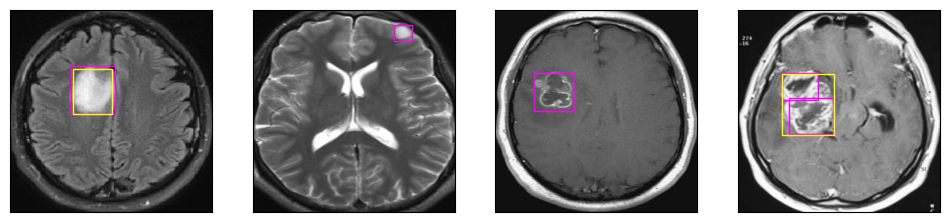

In [24]:
nimages = 4
fig, axs = plt.subplots(ncols=nimages, figsize=(nimages*3,3), subplot_kw={'xticks': [], 'yticks': []})
i = 0
with torch.no_grad():
    model.eval()
    for images, targets in loader_val: 
        if i >= nimages:
            break
        predictions = model([x.to(device) for x in images])
        for image, target, prediction in zip(images, targets, predictions):
            if i >= nimages:
                break
            axs[i].imshow(image.numpy().transpose([1,2,0]))
            for xmin, ymin, xmax, ymax in target['boxes'].numpy():
                axs[i].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, ec='magenta', fc='none'))
            for (xmin, ymin, xmax, ymax), score in zip(prediction['boxes'].cpu().numpy(), prediction['scores'].cpu().numpy()):
                if score < score_threshold:
                    continue
                axs[i].add_patch(plt.Rectangle((xmin, ymin), xmax - xmin + 1, ymax - ymin + 1, ec='yellow', fc='none'))
            i += 1

In [34]:
def intersection_over_union(box_a, box_b):
    xmin = max(box_a[0], box_b[0])
    ymin = max(box_a[1], box_b[1])
    xmax = min(box_a[2], box_b[2])
    ymax = min(box_a[3], box_b[3])
    area_ab = max(0, xmax - xmin + 1) * max(0, ymax - ymin + 1)
    area_a = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    area_b = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
    return 100 * area_ab / (area_a + area_b - area_ab)

*Hint:* Extend analysis below to compute AP and mAP (Q2c).

In [35]:
def calculate_metrics(thresholds, loader_val, model):
    precision, recall = [], []
    n_thresholds = len(thresholds)

    with torch.no_grad():
        model.eval()
        iou_idx = 0
        while iou_idx < n_thresholds:
            score_idx = 0
            while score_idx < n_thresholds:
                TP, FP, GT = 0, 0, 0
                for images, targets in loader_val:
                    predictions = model([x.to(device) for x in images])
                    TP, FP, GT = process_predictions(targets, predictions, TP, FP, GT, thresholds[iou_idx], thresholds[score_idx])
                precision.append(TP / (TP + FP))
                recall.append(TP / GT)
                score_idx += 1
            iou_idx += 1

    return precision, recall

def process_predictions(targets, predictions, TP, FP, GT, iou_t, score_t):
    ious = []
    for target, prediction in zip(targets, predictions):
        for box_a in target['boxes'].numpy():
            iou_max = 0
            for box_b, score in zip(prediction['boxes'].cpu().numpy(), prediction['scores'].cpu().numpy()):
                if score < score_t:
                    if intersection_over_union(box_a, box_b) > iou_t:
                        GT += 1
                    continue

                iou = intersection_over_union(box_a, box_b)
                iou_max = max(iou_max, iou)

                if iou > iou_t:
                    TP += 1
                    GT += 1
                else:
                    FP += 1

            ious.append(iou_max)
    return TP, FP, GT

thresholds = np.arange(0, 0.95, 0.1)
precision, recall = calculate_metrics(thresholds, loader_val, model)


<ipython-input-5-edf59ec4f5c3>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


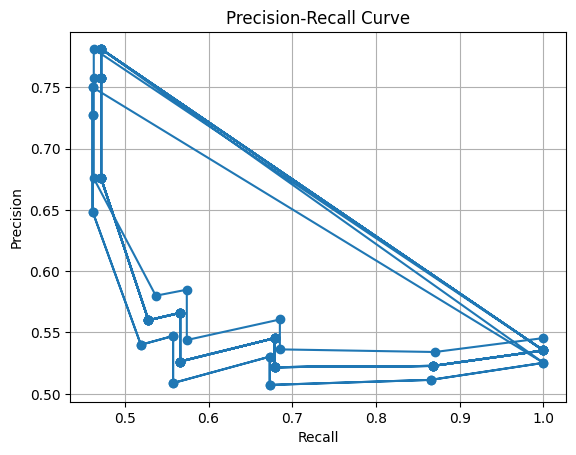

In [36]:
ious = []
iou_thresholds = np.linspace(0.5, 0.95, 10)

plt.figure()
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

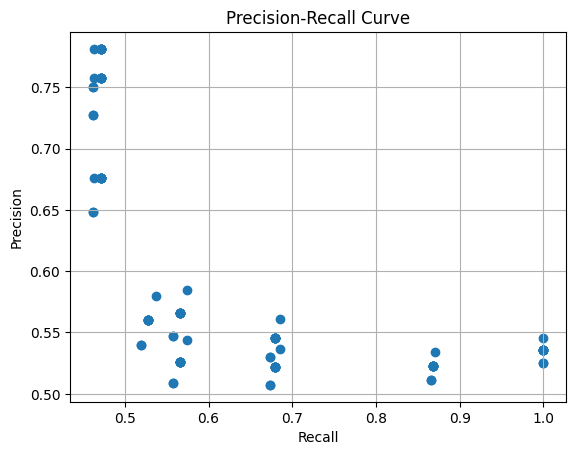

In [41]:
plt.figure()
plt.scatter(recall, precision, marker='o')  # Use scatter instead of plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

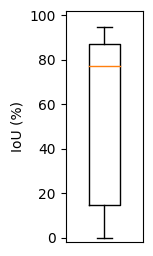

In [ ]:
fig, ax = plt.subplots(figsize=(1,3))
ax.boxplot(ious, widths=0.4)
ax.set_xticks([])
ax.set_ylim(-2, 102)
ax.set_ylabel('IoU (%)')
pass

<ipython-input-6-eb29b4faa048>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


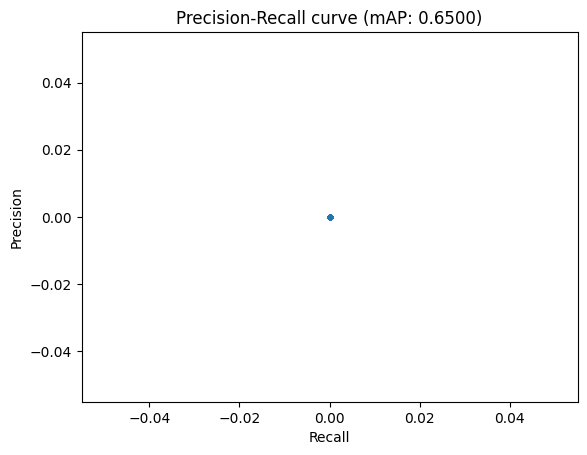

In [ ]:
# another way to attempt the result
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import average_precision_score

def intersection_over_union(box_a, box_b):
    x1 = max(box_a[0], box_b[0])
    y1 = max(box_a[1], box_b[1])
    x2 = min(box_a[2], box_b[2])
    y2 = min(box_a[3], box_b[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)

    iou = intersection_area / float(box_a_area + box_b_area - intersection_area)
    return iou

def compute_ap(recall, precision):
    recall = np.concatenate(([0.], recall, [1.]))
    precision = np.concatenate(([0.], precision, [0.]))

    for i in range(precision.size - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0] + 1
    ap = np.sum((recall[indices] - recall[indices - 1]) * precision[indices])
    return ap

iou_thresholds = np.linspace(0.5, 0.95, 10)
aps = []

for iou_threshold in iou_thresholds:
    preds = defaultdict(list)
    gts = defaultdict(list)

    with torch.no_grad():
        model.eval()
        for images, targets in loader_val:
            predictions = model([x.to(device) for x in images])
            for target, prediction in zip(targets, predictions):
                image_id = target['image_id'].item()
                gts[image_id].extend(target['boxes'].numpy())
                preds[image_id].extend(zip(prediction['boxes'].cpu().numpy(), prediction['scores'].cpu().numpy()))

    recs = []
    precs = []
    for gt_boxes, pred_boxes_scores in zip(gts.values(), preds.values()):
        pred_boxes, pred_scores = zip(*pred_boxes_scores)
        gt_flags = [False] * len(gt_boxes)
        sorted_idxs = np.argsort(pred_scores)[::-1]

        tp = 0
        fp = 0
        for idx in sorted_idxs:
            pred_box = pred_boxes[idx]
            pred_score = pred_scores[idx]

            iou_max = 0
            max_gt_idx = -1
            for gt_idx, (gt_box, gt_flag) in enumerate(zip(gt_boxes, gt_flags)):
                if gt_flag:
                    continue
                iou = intersection_over_union(pred_box, gt_box)
                if iou > iou_max:
                    iou_max = iou
                    max_gt_idx = gt_idx
                                       
            if iou_max >= iou_threshold:
                if not gt_flags[max_gt_idx]:
                    tp += 1
                    gt_flags[max_gt_idx] = True
            else:
                fp += 1

            rec = tp / len(gt_boxes)
            prec = tp / (tp + fp)
            recs.append(rec)
            precs.append(prec)

    ap = compute_ap(np.array(recs), np.array(precs))
    aps.append(ap)

mAP = np.mean(aps)

# Plotting the Precision-Recall curve
plt.figure()
plt.plot(recs, precs, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (mAP: {mAP:.4f})')
plt.show()



---
<small>Uneri & Sisniega, 2023</small>